In [1]:
import pandas as pd
import re
import sys
from pandas_datareader import data
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
mean_df = pd.read_csv('Dados/Dados_com_pol')

In [3]:
mean_df.head()

,data,High,Low,Open,Close,Volume,Adj Close,text_polaridade,Variacao,norm
0,2015-01-02,50005.0,48345.0,50005.0,48512.0,2882100.0,48512.0,-0.211567,NaN,NaN
1,2015-01-05,48512.0,47264.0,48512.0,47517.0,3866100.0,47517.0,-0.504833,-2.051039,0.438297
2,2015-01-06,48061.0,47338.0,47517.0,48001.0,4559300.0,48001.0,0.250073,1.018583,0.637670
3,2015-01-07,49882.0,48006.0,48006.0,49463.0,4408800.0,49463.0,-0.096823,3.045770,0.769336
4,2015-01-08,50261.0,49017.0,49463.0,49943.0,3621900.0,49943.0,-0.399386,0.970422,0.634542


In [4]:
df1 = mean_df['Close']
df2 = mean_df['text_polaridade']
df3 = mean_df['Variacao']

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1_scale = (np.array(df1).reshape(-1,1))
scaler_pol = MinMaxScaler(feature_range=(0,1))
data = np.hstack((df1_scale, (np.array(df2).reshape(-1,1))))
data = pd.DataFrame(data, columns=['Preço', 'Sentimento'])

In [11]:
data_split = 1
particoes = 20
all_data = np.array_split(data,data_split)

In [12]:
train = []
test = []
for data_chunk in all_data:
    split = 0.7
    train_test_split = int(split*len(data_chunk))
    train.append(data_chunk[:train_test_split])
    test.append(data_chunk[train_test_split:])

In [13]:
from pyFTS.common import Transformations
tdiff = Transformations.Differential(1)

In [14]:
from pyFTS.partitioners import Grid, Entropy, Util as pUtil
from pyFTS.models.multivariate import common, variable, mvfts

<IPython.core.display.Javascript object>


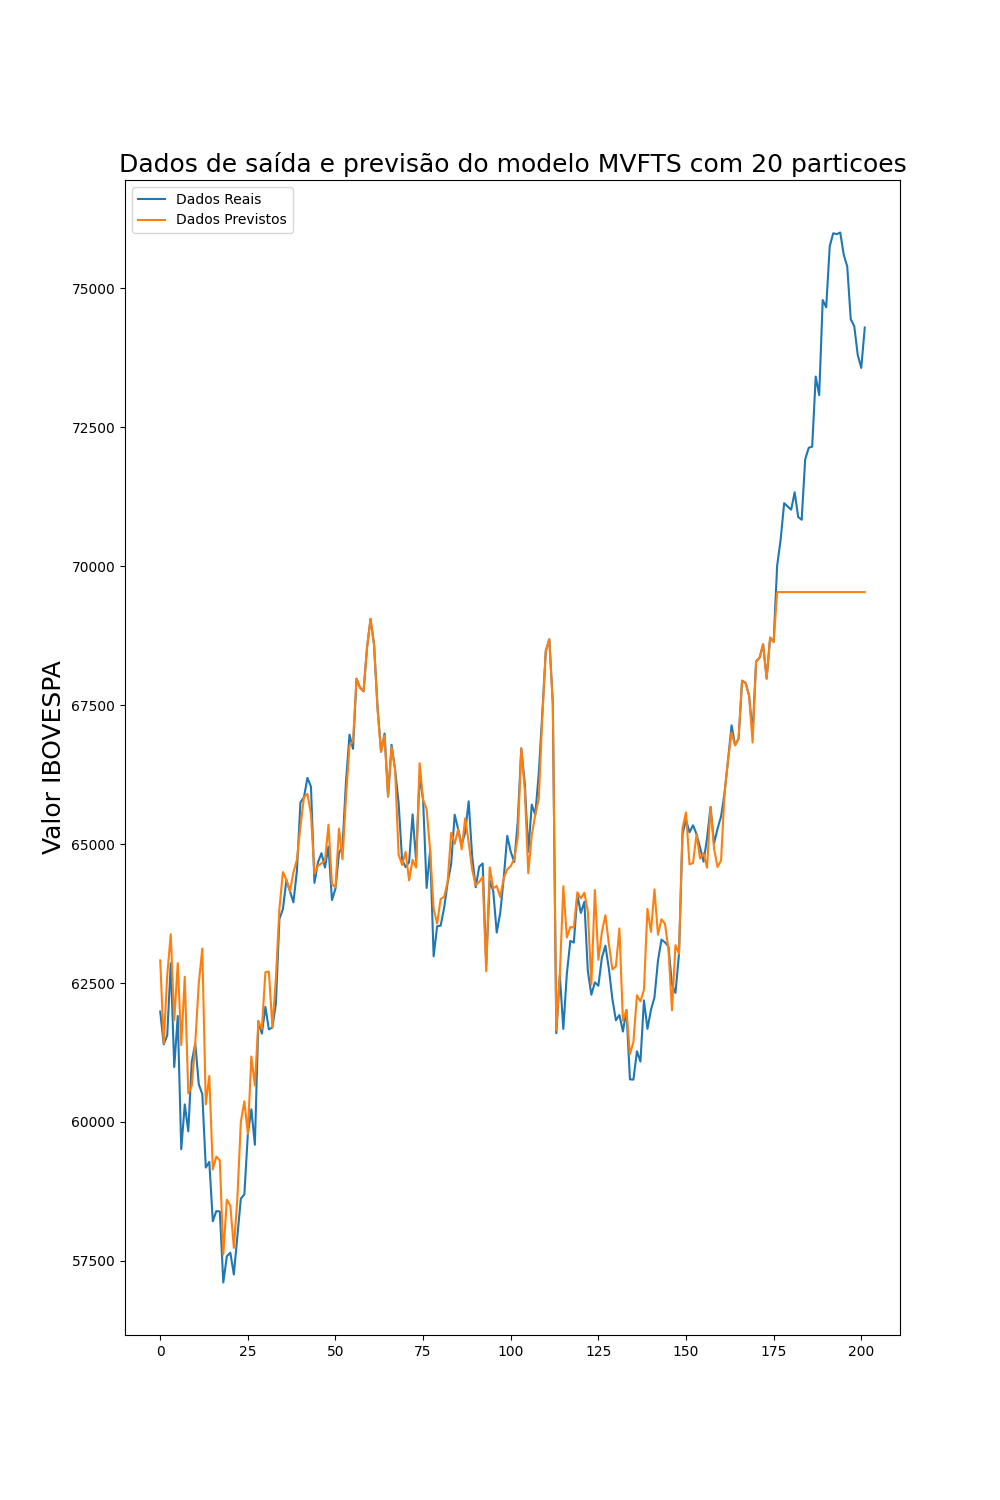

       Preço  Sentimento
0    48512.0   -0.211567
1    47517.0   -0.504833
2    48001.0    0.250073
3    49463.0   -0.096823
4    49943.0   -0.399386
..       ...         ...
463  60759.0    0.097915
464  59770.0    0.024095
465  59962.0   -0.006610
466  61070.0    0.183125
467  61954.0    0.194238

[468 rows x 2 columns]


In [41]:
fig, axs = plt.subplots(data_split, figsize=(10,15))
modelmfts = []

for i, (train_chunk, test_chunk) in enumerate(zip(train, test)):
    preco = variable.Variable("Preço", data_label="Preço", npart=particoes,data=train_chunk)
    sentimento = variable.Variable("Sentimento", data_label="Sentimento", npart=particoes,data=train_chunk)
    modelmfts.append(mvfts.MVFTS())
    modelmfts[i].append_variable(preco)
    modelmfts[i].append_variable(sentimento)
    modelmfts[i].target_variable = preco
    modelmfts[i].fit(train_chunk)
    forecasts = modelmfts[i].predict(test_chunk)
    if data_split == 1:
        axs.set_ylabel('Valor IBOVESPA', fontsize=18)
        axs.plot(test_chunk['Preço'].values)
        axs.plot(forecasts)
        axs.legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        axs.set_title(f'Dados de saída e previsão do modelo MVFTS com {particoes} particoes', fontsize = 18)
    else: 
        axs[i].set_ylabel('Valor IBOVESPA', fontsize=12)
        axs[i].plot(test_chunk['Preço'].values)
        axs[i].plot(forecasts)
        axs[i].legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        fig.suptitle(f'Dados de saída e previsão do modelo MVFTS quando dados estão divididos em {data_split} com {particoes} particoes')
        fig.subplots_adjust(top=0.95)
plt.show()

<IPython.core.display.Javascript object>


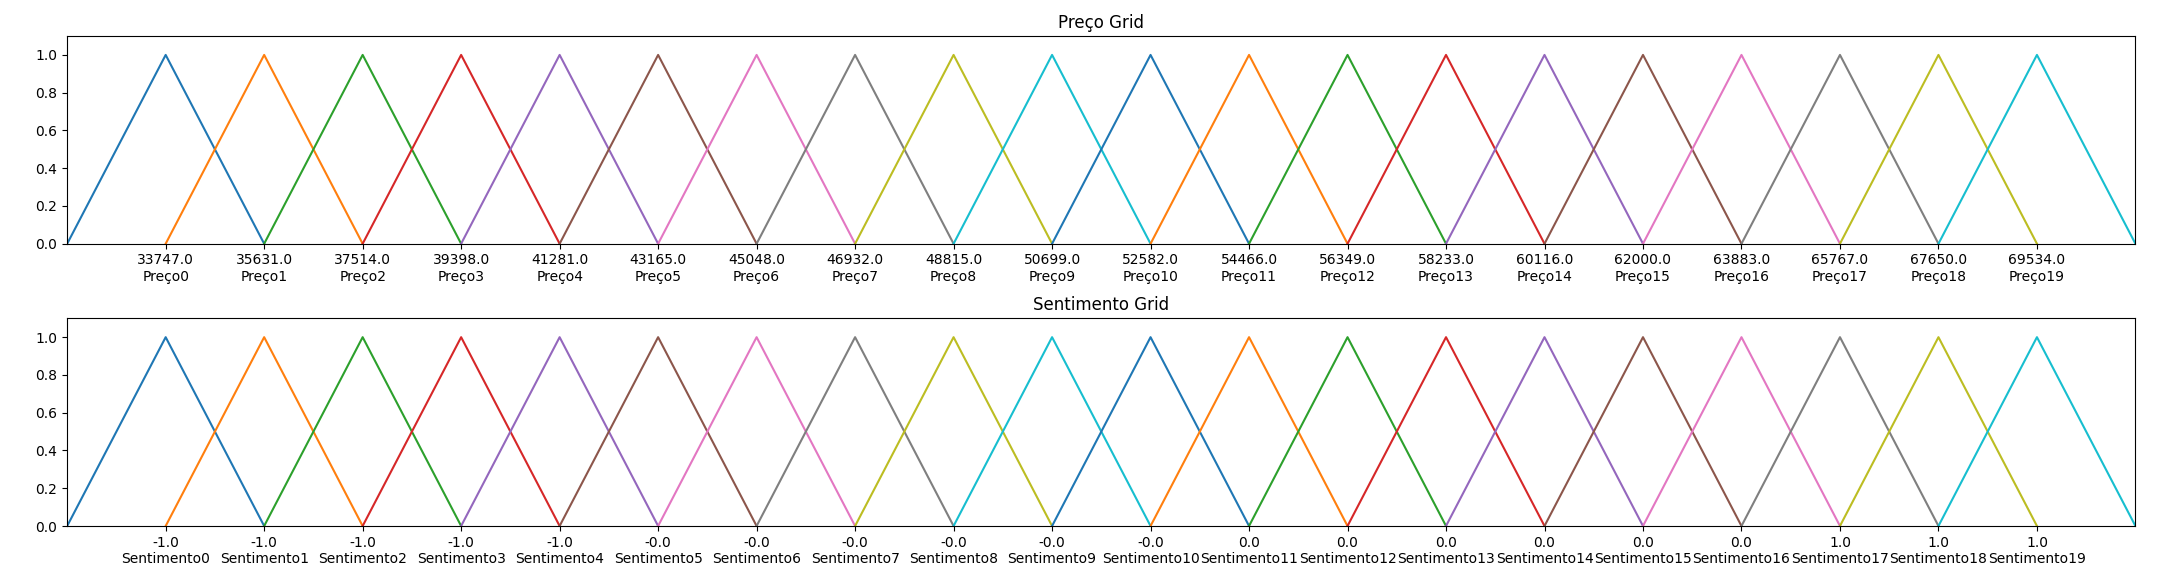

In [50]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[15,6])
preco.partitioner.plot(ax[0])
sentimento.partitioner.plot(ax[1])
plt.tight_layout()

<IPython.core.display.Javascript object>


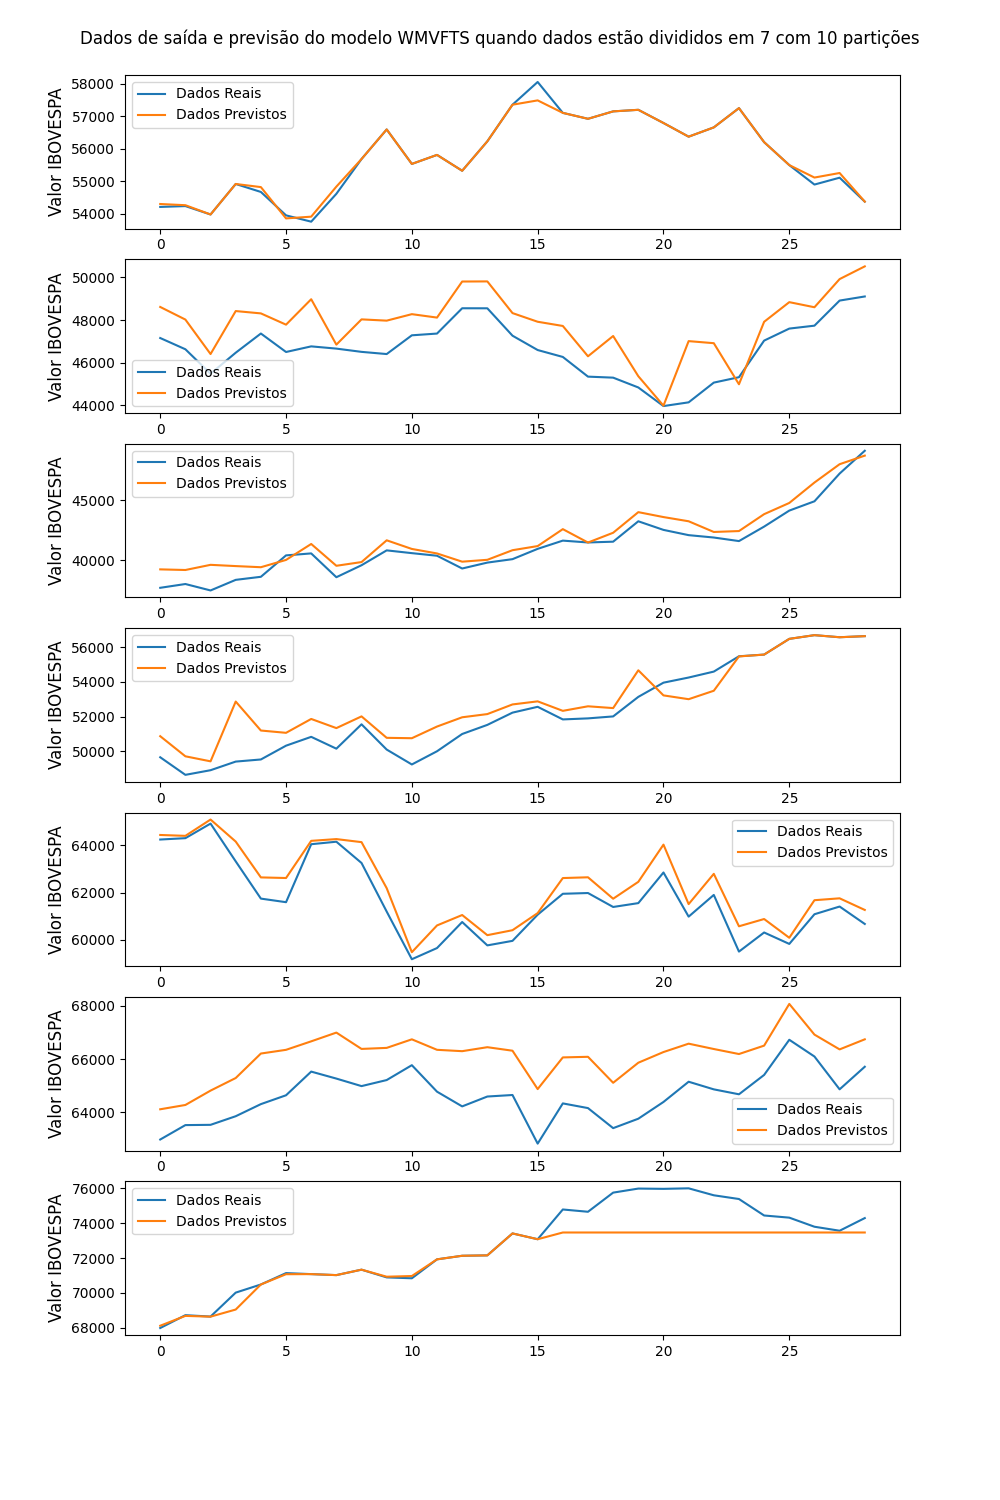

In [29]:
from pyFTS.models.multivariate import mvfts, wmvfts, granular
fig, axs = plt.subplots(data_split, figsize=(10,15))

modelWVFTS = []

for i, (train_chunk, test_chunk) in enumerate(zip(train, test)):
    preco = variable.Variable("Preço", data_label="Preço", npart=particoes,data=train_chunk)
    sentimento = variable.Variable("Sentimento", data_label="Sentimento", npart=particoes,data=train_chunk)
    modelWVFTS.append(wmvfts.WeightedMVFTS())
    modelWVFTS[i].append_variable(preco)
    modelWVFTS[i].append_variable(sentimento)
    modelWVFTS[i].target_variable = preco
    modelWVFTS[i].fit(train_chunk)
    forecasts = modelWVFTS[i].predict(test_chunk)
    if data_split == 1:
        axs.set_ylabel('Valor IBOVESPA', fontsize=18)
        axs.plot(test_chunk['Preço'].values)
        axs.plot(forecasts)
        axs.legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        axs.set_title(f'Dados de saída e previsão do modelo WMVFTS com {particoes} particoes', fontsize = 18)
    else: 
        axs[i].set_ylabel('Valor IBOVESPA', fontsize=12)
        axs[i].plot(test_chunk['Preço'].values)
        axs[i].plot(forecasts)
        axs[i].legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        fig.suptitle(f'Dados de saída e previsão do modelo WMVFTS quando dados estão divididos em {data_split} com {particoes} partições')
        fig.subplots_adjust(top=0.95)
plt.show()


<IPython.core.display.Javascript object>


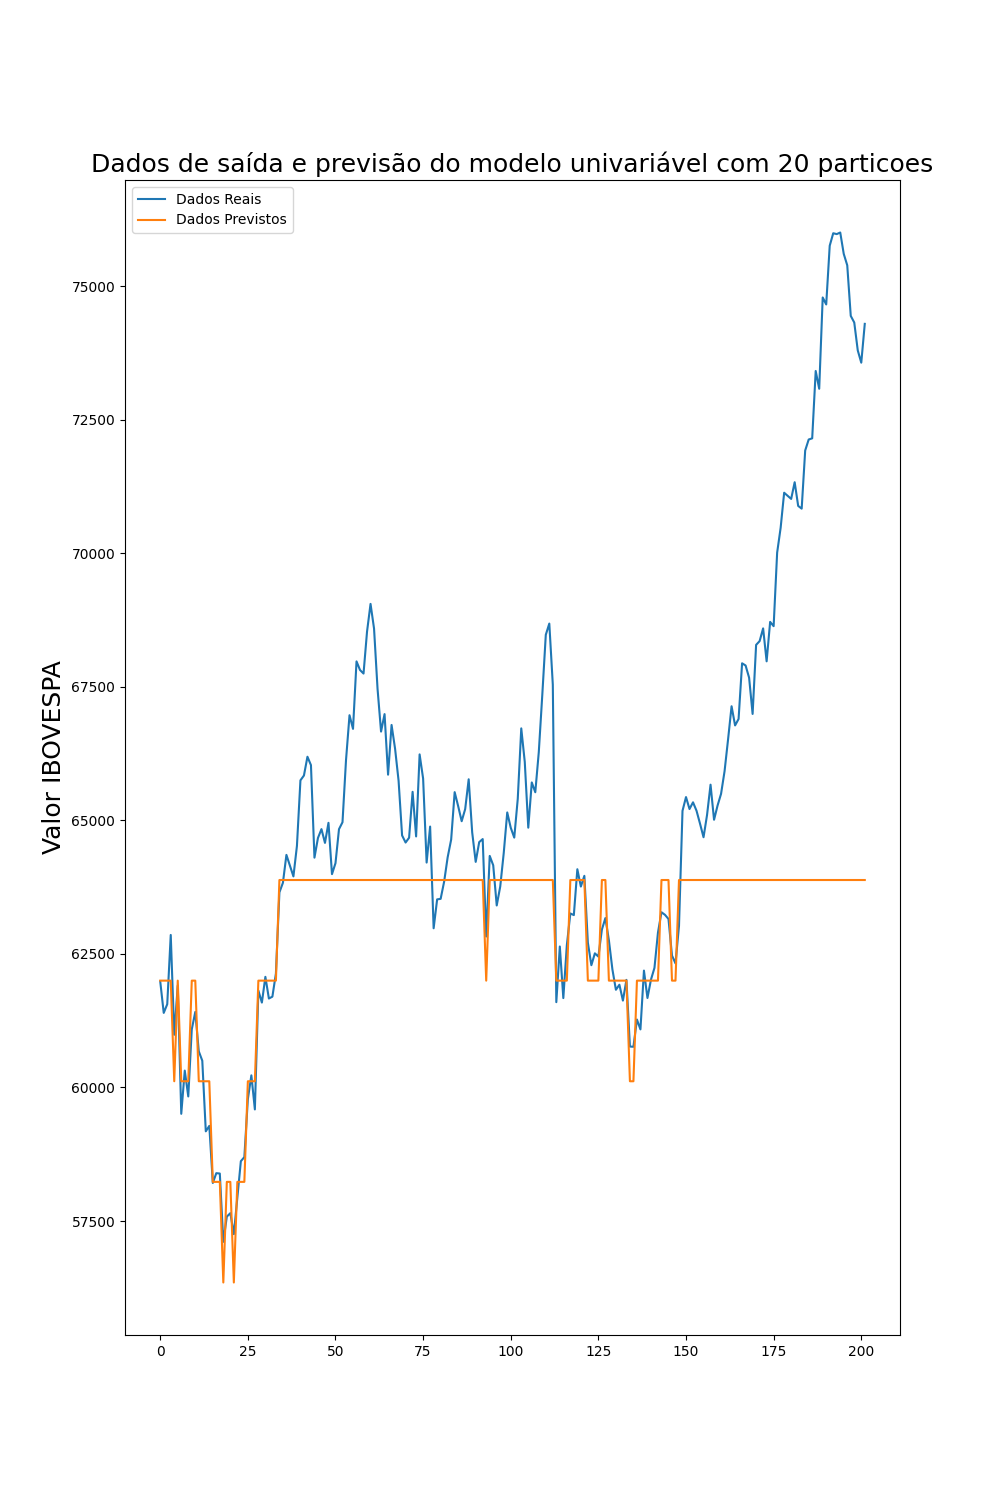

In [23]:
from pyFTS.models import chen
fig, axs = plt.subplots(data_split, figsize=(10,15))
model = []


for i, (train_chunk, test_chunk) in enumerate(zip(train, test)):
    tdiff = Transformations.Differential(1)
    fs = Grid.GridPartitioner(data=train_chunk.Preço.values, npart=particoes)    
    model.append(chen.ConventionalFTS(partitioner=fs))
    model[i].fit(train_chunk.Preço.values)
    forecasts = model[i].predict(test_chunk.Preço.values)
    if data_split == 1:
        axs.set_ylabel('Valor IBOVESPA', fontsize=18)
        axs.plot(test_chunk['Preço'].values)
        axs.plot(forecasts)
        axs.legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        axs.set_title(f'Dados de saída e previsão do modelo univariável com {particoes} particoes', fontsize = 18)
    else: 
        axs[i].set_ylabel('Valor IBOVESPA', fontsize=12)
        axs[i].plot(test_chunk['Preço'].values)
        axs[i].plot(forecasts)
        axs[i].legend(['Dados Reais','Dados Previstos', 'Dados de Treino'])
        fig.suptitle(f'Dados de saída e previsão do modelo univariável quando dados estão divididos em {data_split} com {particoes} particoes')
        fig.subplots_adjust(top=0.95)
plt.show()

In [36]:
from pyFTS.common import Util
Util.plot_rules(model[0])

<IPython.core.display.Javascript object>

ValueError: The number of FixedLocator locations (20), usually from a call to set_ticks, does not match the number of ticklabels (21).

In [20]:
from pyFTS.benchmarks import Measures
rmseUNI,smapeUNI = [], []
rmseMV,smapeMV = [], []
rmseWMV,smapeWMV = [], []
for i, test_chunk in enumerate(test):
    rmseUNI.append(Measures.get_point_statistics(test_chunk.Preço, model[i])[0])
    smapeUNI.append(Measures.get_point_statistics(test_chunk.Preço, model[i])[1])
    rmseMV.append(Measures.get_point_statistics(test_chunk, modelmfts[i])[0])
    smapeMV.append(Measures.get_point_statistics(test_chunk, modelmfts[i])[1])
    rmseWMV.append(Measures.get_point_statistics(test_chunk, modelWVFTS[i])[0])
    smapeWMV.append(Measures.get_point_statistics(test_chunk, modelWVFTS[i])[1])


In [16]:
print(f'RMSE -- UNI:{np.mean(rmseUNI)} ,MV:{np.mean(rmseMV)}, WMV: {np.mean(rmseWMV)}')
print(f'SMAPE -- UNI:{np.mean(smapeUNI)}, MV:{np.mean(smapeMV)}, WMV: {np.mean(smapeWMV)}')

RMSE -- UNI:5088.57 ,MV:1732.35, WMV: 1554.54
SMAPE -- UNI:5.59, MV:2.0, WMV: 1.71


In [17]:
def signal(close, pred):
    signal = []
    signal.append(1)
    last_op = 0
    for i in range(1,len(close)):
        if pred[i] > close[i]:
            if signal[last_op] == -1:
                last_op = i
                signal.append(1)
            else:
                signal.append(0)
        elif pred[i] < close[i]:
            if signal[last_op] == 1:
                last_op = i
                signal.append(-1)
            else:
                signal.append(0)
        #print(pred[i]>close[i], i, signal, last_op)
        else:
            signal.append(0)
    return signal

In [20]:
valid = mean_df[train_test_split:]
valid['Predictions'] = forecasts

<ipython-input-20-dbe2efe9a09a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = forecasts


In [21]:
signal_val = signal(np.array(valid.Predictions), np.array(valid.Predictions.shift(-1)))

In [22]:
valid['Signal'] = signal_val
df = valid[['data','Signal','Close']]
bt_data = valid[['data', 'High','Low', 'Open', 'Close', 'Volume']]
bt_data.index = pd.to_datetime(bt_data.data)

<ipython-input-22-9f568b4452ab>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Signal'] = signal_val


In [23]:
orders = df.to_numpy()

<IPython.core.display.Javascript object>


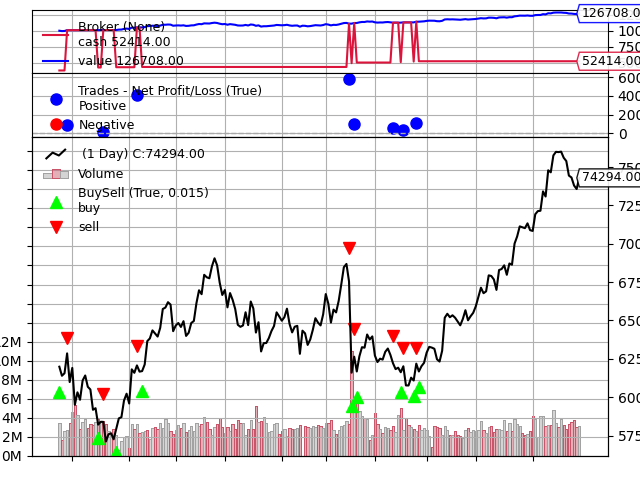

Ending Portfolio Value: 126.708 %


In [24]:
%matplotlib notebook
import backtrader as bt

start_cash = 100000

cerebro = bt.Cerebro()
cerebro.broker.setcash(start_cash)
feed = bt.feeds.PandasData(dataname=bt_data)
cerebro.adddata(feed)
cerebro.add_order_history(orders, notify=True)
cerebro.run()
cerebro.plot(style = 'line')
print(f'Ending Portfolio Value: {(cerebro.broker.getvalue()/start_cash)*100} %')
plt.show()

<ipython-input-20-bfd2246f5f44>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = forecasts[:-10]
<ipython-input-20-bfd2246f5f44>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Signal'] = signal_val


<IPython.core.display.Javascript object>


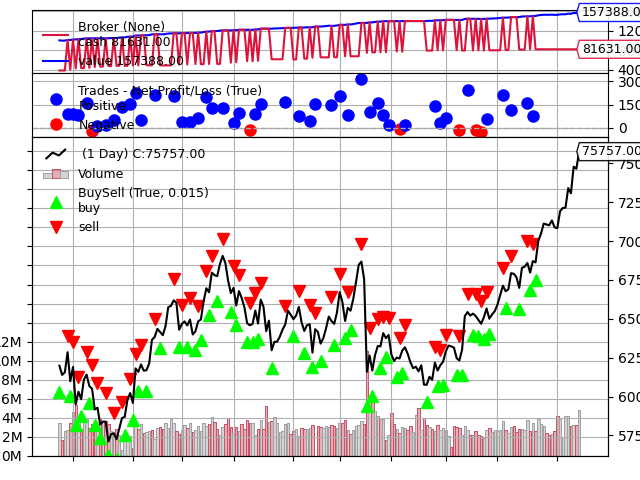

Ending Portfolio Value: 157.388 %


In [20]:
valid = mean_df[train_test_split:-10]
valid['Predictions'] = forecasts[:-10]
signal_val = signal(np.array(valid.Predictions), np.array(valid.Predictions.shift(-1)))
valid['Signal'] = signal_val
df = valid[['data','Signal','Close']]
bt_data = valid[['data', 'High','Low', 'Open', 'Close', 'Volume']]
bt_data.index = pd.to_datetime(bt_data.data)
orders = df.to_numpy()
%matplotlib notebook
import backtrader as bt

start_cash = 100000

cerebro = bt.Cerebro()
cerebro.broker.setcash(start_cash)
feed = bt.feeds.PandasData(dataname=bt_data)
cerebro.adddata(feed)
cerebro.add_order_history(orders, notify=True)
cerebro.run()
cerebro.plot(style = 'line')
print(f'Ending Portfolio Value: {(cerebro.broker.getvalue()/start_cash)*100} %')
plt.show()